# Lyric Mood Classification - Mood Classification

In the [word_embeddings](word_embeddings.ipynb) notebook, we demonstrated our embeddings model based on word2vec. In this notebook, we use those embeddings to produce real classification results with a neural network.

First, we split our labeled data into the classic train-dev-test split.

Second, we establish a baseline classification with simple classifiers.

Third, we demonstrate our neural network architecture and model for mood classification.

In [153]:
import os
import collections
import time
import pandas as pd
import numpy as np
import string
import random
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

from index_lyrics import read_file_contents
from label_lyrics import CSV_LABELED_LYRICS
from scrape_lyrics import LYRICS_TXT_DIR

import math

## Dataset

The dataset consists of a large number of text files where each file represents a different song. The songs are indexed by a csv file produced by `label_lyrics.py`. We can use the index to retrieve a song's lyrics and observe its matched mood.

We drop all songs that are not english, do not have lyrics available, and do not have a matched mood as classifying across languages is out of scope of this project and no classification can be done on a song without lyrics or without a matched mood.

In [154]:
# we leave out the musixmatch id, artist, and title cols
df = pd.read_csv(CSV_LABELED_LYRICS, usecols=['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available', 'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'])
df.columns

Index(['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available',
       'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'],
      dtype='object')

In [155]:
print('Df shape:', df.shape)
df.describe()

Df shape: (779056, 10)


,is_english,lyrics_available,wordcount,found_tags,matched_mood
count,779056.000000,779056.000000,779056.000000,779056.000000,779056.000000
mean,0.342566,0.420039,87.716389,5.870052,-0.611558
std,0.474571,0.493565,141.151970,19.502538,0.574065
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000
75%,1.000000,1.000000,161.000000,1.000000,0.000000
max,1.000000,1.000000,8623.000000,100.000000,1.000000


In [156]:
df = df[df.is_english == 1]
print('After is_english filter:', df.shape)
df = df[df.lyrics_available == 1]
print('After lyrics_available filter:', df.shape)
df = df[df.matched_mood == 1]
print('After matched_mood filter:', df.shape)

After is_english filter: (266879, 10)
After lyrics_available filter: (266783, 10)
After matched_mood filter: (35835, 10)


In [157]:
# remove no longer needed columns to conserve memory
df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)

In [158]:
# create a categorical data column for moods
# thank you: https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
df.mood = pd.Categorical(df.mood)
df['mood_cats'] = df.mood.cat.codes
print(df['mood_cats'].unique())
print(df.shape)

[ 7  2 14 16  3 15 10  0  4 12  1 11  5  8  9 13  6]
(35835, 8)


In [174]:
# read in the lyrics of each song
def extract_lyrics(lyrics_filepath):
    lyrics = ''
    if os.path.exists(lyrics_filepath):
        lyrics = read_file_contents(lyrics_filepath)[0]
    return lyrics

def make_lyrics_txt_path(lyrics_filename):
    return os.path.join(LYRICS_TXT_DIR, lyrics_filename) + '.txt'

# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics(make_lyrics_txt_path(x)))
df.lyrics.head()

7     Electro eroticism\nIntelligence is sexy\nElect...
19    I'm in the dark, I'd like to read his mind\nBu...
27    I'm in the dark, I'd like to read his mind\nBu...
28    One night in Iowa, he and I in a borrowed car\...
32    Shall we agree that just this once\nI'm gonna ...
Name: lyrics, dtype: object

The final number of songs with a matched mood: 35835


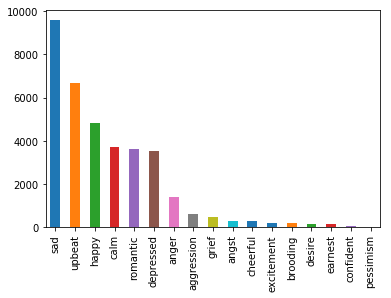

In [175]:
print('The final number of songs with a matched mood:', df.shape[0])
_ = df.mood.value_counts().plot(kind='bar')

## Train, Dev, & Test

With our dataset index in hand, we are prepared to split the data.

In [194]:
# thank you: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
# optional random dataframe shuffle
#df = df.reindex(np.random.permutation(df.index))
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

df_train, df_dev, df_test = split_data(df)

In [195]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (21501, 9)
Dev: (7167, 9)
Test: (7167, 9)


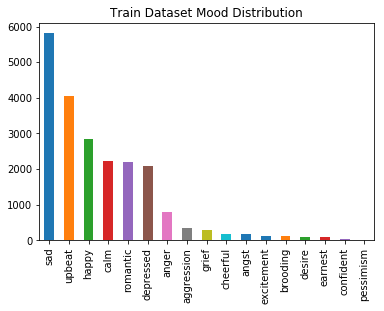

In [178]:
# thank you: https://stackoverflow.com/questions/14992644/turn-pandas-dataframe-of-strings-into-histogram
_ = df_train.mood.value_counts().plot(kind='bar', title='Train Dataset Mood Distribution')

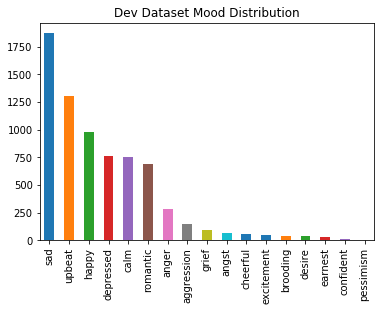

In [179]:
_ = df_dev.mood.value_counts().plot(kind='bar', title='Dev Dataset Mood Distribution')

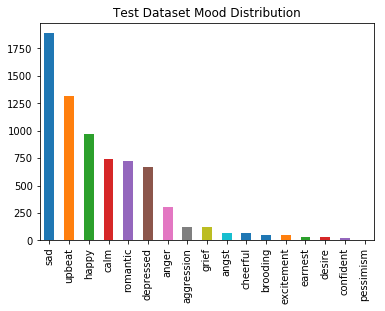

In [180]:
_ = df_test.mood.value_counts().plot(kind='bar', title='Test Dataset Mood Distribution')

## Baselines

### Most-Common-Case Classification

In [181]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

In [182]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.mood.value_counts().idxmax())
print('\tDev:', df_dev.mood.value_counts().idxmax())
print('\tTest:', df_test.mood.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics_filename, df_train.mood)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics_filename, df_dev.mood)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics_filename, df_test.mood)))


The most common case for each dataset split is
	Train: sad
	Dev: sad
	Test: sad
The accuracy of the most-common-case classifier for each dataset split is
	Train: 27.02%
	Dev: 26.11%
	Test: 26.34%


### Naive-Bayes Classification

The Naive-Bayes Classifier will require the actual lyrical text for classification, so we begin by reading into memory the text for each song in our dataset.

Once we have the lyrics, we use the python sklearn package to vectorize and process the lyrical text, fit the Naive Bayes Classifier, and compute the accuracy.

In [198]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(21501, 42154)
(7167, 42154)
(7167, 42154)


In [201]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.mood_cats) 
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 29.64%
Naive Bayes Classifier Dev Accuracy: 30.25%


ValueError: could not convert string to float: "When I was just a little girl\nI asked my mother\nWhat will I be?\nWill I be pretty?\nWill I be rich?\nHere's what she said to me....\nQue sera sera\nWhatever will be, will be\nThe future's not ours to see\nQue sera sera\nWhen I grew up and fell in love\nI asked my lover what lies ahead?\nWill there be rainbows day after day?\nHere's what my lover said.....\nQue sera sera\nWhatever will be, will be\nThe future's not ours to see\nQue sera sera\nQue sera sera\nWhatever will be, will be\nThe future's not ours to see\nQue sera sera"